# Pre-Amble

In [3]:
from gensim.models import Word2Vec
import numpy as np
from scipy.spatial import distance
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import os
from os import listdir
from os.path import isfile, join
import random
from spellchecker import SpellChecker
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collatex import *
import re
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from os import walk
import glob
import pandas as pd
import gensim.downloader as api
from scipy.spatial.distance import cosine
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from scipy import spatial
import scipy.spatial
from gensim import corpora
import shutil

[nltk_data] Downloading package punkt to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Accuracy Measures

In [4]:
#Average Signed Distance
# Number of edges between two nodes
def Distance(graph,node_1,node_2,variants):
    graph=graph.to_undirected()
    shortest_path = nx.shortest_path(graph,node_1, node_2)
    
    return (len(shortest_path)) 

# Matrix of number of edges between two nodes in each graph structure

def Distances(graph1, graph2, variants):
    num_variants = len(variants)
    graph1=graph1.to_undirected()
    graph2=graph2.to_undirected()
    distances_1 = np.zeros((num_variants, num_variants))
    distances_2 = np.zeros((num_variants, num_variants))
    
    for i in range(num_variants):
        for j in range(i + 1, num_variants):
            dist1 = Distance(graph1, variants[i], variants[j],variants)
            distances_1[i][j] = dist1
            distances_1[j][i] = dist1  
            
            dist2 = Distance(graph2, variants[i], variants[j],variants)
            distances_2[i][j] = dist2
            distances_2[j][i] = dist2 
    return distances_1, distances_2

def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

#Distance matrix calculation
def calculate_distances(matrix):
    # Getting the shape of the matrix X
    rows, cols = matrix.shape
    # Initialize an empty list to store the results
    results = []
    # Loop through each row index i
    for i in range(rows):
        # Loop through each column index j where j is distinct from i
        for j in range(cols):
            if j != i:
                # Loop through each column index k where k is distinct from i and j
                for k in range(cols):
                    if k != j and k!=i:
                        # Calculate d[i, j] - d[i, k]
                        results.append(sign(matrix[i, j] - matrix[i, k]))
    return results

# Signed Distance
def Signed_Distance(graph1,graph2,variants):
    graph1=graph1.to_undirected()
    graph2=graph2.to_undirected()
    a,b=Distances(graph1,graph2,variants)
    a_distances = calculate_distances(a)
    b_distances = calculate_distances(b)
    triplets=[]
    for i in range(len(a_distances)):
        triplets.append(1-0.5*(abs(a_distances[i]-b_distances[i])))
    return 100*np.sum(triplets)/len(triplets)

# Accuracy functions for trees with no latent nodes
def get_leaves(g):
    return [node for node, degree in g.degree() if degree == 1]


def get_directed_edges(graph):
    directed_edges = [(u, v) for u, v in graph.edges() if graph.has_edge(u, v)]
    return directed_edges


def digraph_to_graph(digraph):
    undirected_graph = digraph.to_undirected()
    undirected_edges = list(undirected_graph.edges())
    return undirected_edges


def get_ancestries(graph):
    ancestries = {}
    
    for node in graph.nodes():
        ancestries[node] = list(nx.ancestors(graph, node))
    return list(ancestries.items())

def format_tuples_to_strings(tuple_list):
    # Use list comprehension to format each tuple as a string
    return [str(t) for t in tuple_list]
    
def depth(reconstructed,true):
    reconstructed_root=[n for n,d in reconstructed.in_degree() if d==0][0]
    true_root=[n for n,d in true.in_degree() if d==0][0]
    return len(nx.shortest_path(true.to_undirected(), reconstructed_root,true_root))
#root heuristic (if roots agree give 1 else 0)
def root(graph_1,graph_2):
    root_1 = [node for node, in_degree in graph_1.in_degree() if in_degree == 0]
    root_2 = [node for node, in_degree in graph_2.in_degree() if in_degree == 0]
    if root_1[0] == root_2[0]:
        return 1
    else:
        return 0
# Minimum Cost Heuristic 
def sum_branch_lengths(graph, source_node):
    # Compute shortest paths from the source node to all other nodes
    shortest_paths = nx.single_source_dijkstra_path_length(graph, source_node)
    
    # Sum the lengths of the shortest paths
    total_length = sum(shortest_paths.values())
    
    return total_length
    
def minimum_heuristic(graph):
    node_list = list(graph.nodes())
    node=[]
    for i in node_list:
        heuristic=sum_branch_lengths(graph,i)
        node.append((i,heuristic))
    sorted_nodes = sorted(node, key=lambda x: x[1])

    return sorted_nodes[0][0]

# Root the tree and direct edges away from root using depth first search
def direct_edges_away_from_root(graph, root):

    directed_tree = nx.DiGraph()

    # Depth First Search to traverse the tree and then point edges away from the root
    def dfs(node, parent):
        for neighbor in graph.neighbors(node):
            if neighbor != parent:
                # Reverse the edge direction
                directed_tree.add_edge(neighbor, node)
                # Recursively visit the neighbour
                dfs(neighbor, node)

    # Start DFS from the root
    dfs(root, None)
    # Reverse edges to point away rather than towards the root
    return nx.reverse(directed_tree)


# Misspelling

In [5]:
#READ MISPELLING DATA
#Here we merge the misspellings datasets into one dictionary {{word}:{[list of misspellings]}}
import os
from os import listdir
from os.path import isfile, join

from os import walk
import json

import re
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def read_text_files(directory):
    file_contents = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Check if it's a text file
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                content = file.read()
                file_contents.append(remove_numbers(content))
    
    return file_contents
file_contents = read_text_files("C:/Users/Darren Zammit/Desktop/Thesis/datasets/misspellings")
a='\n'.join(file_contents)
a=a.split('$')

a=[x for x in a if x != '']

word_dicts = []

for item in a:
    word_data = item.strip().split('\n')
    correct_word = word_data[0]
    misspellings = word_data[1:]
    word_dict = {
        "word": correct_word,
        "misspellings": misspellings
    }
    word_dicts.append(word_dict)

merged_word_dicts = {}

for word_dict in word_dicts:
    word = word_dict["word"]
    if word in merged_word_dicts:
        merged_word_dicts[word]["misspellings"].extend(word_dict["misspellings"])
    else:
        merged_word_dicts[word] = {
            "word": word,
            "misspellings": word_dict["misspellings"]
        }

merged_word_dicts
#words = {entry['word'] for entry in merged_word_dicts.values()}
#for entry in merged_word_dicts.values():
#    entry['misspellings'] = [misspelling for misspelling in entry['misspellings'] if misspelling not in words]
#merged_word_dicts

#no_misspellings = {key: value for key, value in merged_word_dicts.items() if not value['misspellings']}
#no_misspellings

{'Nevada': {'word': 'Nevada', 'misspellings': ['nevade']},
 'Presbyterian': {'word': 'Presbyterian', 'misspellings': ['presbyterian']},
 'RSX': {'word': 'RSX', 'misspellings': ['rsx']},
 'Stephen': {'word': 'Stephen', 'misspellings': ['Steffen']},
 'Susan': {'word': 'Susan', 'misspellings': ['susan']},
 'ability': {'word': 'ability',
  'misspellings': ['abilitey',
   'abbility',
   'abilaty',
   'abillity',
   'abilty',
   'ablity']},
 'about': {'word': 'about',
  'misspellings': ['abouy',
   'a_belt',
   'a_bot',
   'a_bout',
   'a_but',
   'a_pelt',
   'aboat',
   'aboit',
   'abont',
   'aboo',
   'abot',
   'abote',
   'abou',
   'abought',
   'abould',
   'abound',
   'abowt',
   'abunt',
   'abuot',
   'ad',
   'adeaut',
   'adot',
   'adout',
   'arand',
   'bout',
   'of',
   'out',
   'to',
   'urbote',
   'a_Bat ',
   'a_bout',
   'baout',
   'boaut']},
 'absorption': {'word': 'absorption',
  'misspellings': ['absorbtion', 'absorbtion', 'absorbsion', 'absorbtion']},
 'acciden

In [6]:
import re
import random
#misspell a word at random from a text

def misspell(text, dictionary):
    # Find all words in the text (including punctuation)
    words_with_punctuation = re.findall(r'\b\w+\b', text)

    # Filter words without punctuation
    words = [word.lower() for word in words_with_punctuation if word.isalnum()]

    # Find words in the text that are present in the dictionary
    valid_words = [word for word in words if any(word == entry['word'].lower() for entry in dictionary.values())]

    if not valid_words:
        return text  # If no valid words found, return the original text

    # Randomly select a word from the list of valid words
    word_to_replace = random.choice(valid_words)

    # Find the corresponding entry in the dictionary
    entry = next(entry for entry in dictionary.values() if entry['word'].lower() == word_to_replace)

    # Randomly select a misspelling for the chosen word
    misspelling = random.choice(entry['misspellings'])

    # Replace only one randomly chosen instance of the chosen word in the original text
    def replace_first(match):
        # This inner function ensures we replace only one instance
        replace_first.counter += 1
        return misspelling if replace_first.counter == replace_first.target else match.group(0)

    # Initializing counter and selecting a random target to replace
    replace_first.counter = 0
    occurrences = text.lower().count(word_to_replace)
    replace_first.target = random.randint(1, occurrences) if occurrences > 1 else 1

    # Perform the replacement
    replaced_text = re.sub(r'\b' + re.escape(word_to_replace) + r'\b', replace_first, text, flags=re.IGNORECASE)

    return replaced_text

#print(misspell('ability, butter.', merged_word_dicts))

content="""ability, ability! ability. ability/"""
for i in range(4):
    content=misspell(content,merged_word_dicts)
print(content)

abilitey, ablity! abilaty. abilaty/


In [7]:
import random
import re
#correct a word at random
def correct_misspelled_word(text, dictionary):
    # Extract misspelled words from the dictionary
    misspelled_words = [misspelling for entry in dictionary.values() for misspelling in entry['misspellings']]

    # Find misspelled words in the text
    words_with_punctuation = re.findall(r'\b\w+\b', text)
    misspelled_words_in_text = [word for word in words_with_punctuation if word.lower() in misspelled_words]
# If no misspelled words found, return the original text
    if not misspelled_words_in_text:
        return text  

    # Randomly select a misspelled word from the list
    misspelled_word = random.choice(misspelled_words_in_text)

    # Find the corresponding correct spelling in the dictionary
    correct_spelling = next((entry['word'] for entry in dictionary.values() if misspelled_word.lower() in entry['misspellings']), None)

    if correct_spelling:
        # Randomly decide which instance of the misspelled word to replace
        all_occurrences = [match.start() for match in re.finditer(r'\b' + re.escape(misspelled_word) + r'\b', text)]
        if not all_occurrences:
            return text
        random_occurrence_index = random.choice(all_occurrences)

        # Replace only the randomly selected occurrence of the misspelled word
        corrected_text = (text[:random_occurrence_index] + 
                          re.sub(r'\b' + re.escape(misspelled_word) + r'\b', correct_spelling, text[random_occurrence_index:], count=1))

        return corrected_text
    else:
        return text

print(correct_misspelled_word("abilitey abilitey abilitey abilitey", merged_word_dicts))

ability abilitey abilitey abilitey


In [1]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
#replace a word at random with a synonym
def replace_with_synonym(text):
    words = nltk.word_tokenize(text)
    #do not replace stop words
    stop_words = set(stopwords.words('english'))  # Use a set for faster lookup
    
    # Create a list of words that are not stop words or single letters, have synonyms 
    #(if you include stopwords it may lead to weird replacements for example 'a' 
    # could be replaced with angstrom or some chemical)
    replaceable_words = [word for word in words if word not in stop_words and wn.synsets(word) and len(word)>1]
    if not replaceable_words:
        return text
    
    word_to_replace = random.choice(replaceable_words)
    synonyms = set()
    for syn in wn.synsets(word_to_replace):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word_to_replace in synonyms:
        synonyms.remove(word_to_replace)
    
    if not synonyms:
        return text
    
    synonym_to_replace = random.choice(list(synonyms))
    replaced_text = text.replace(word_to_replace, synonym_to_replace, 1)
    
    return replaced_text

text = "ability"
replaced_text = replace_with_synonym(text)
print(replaced_text)


[nltk_data] Downloading package punkt to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'stopwords' is not defined

In [52]:
import random
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#remove an adjective or adverb at random
def remove_adj_adv(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Tag each token with part-of-speech
    tagged_tokens = pos_tag(tokens)
    
    # Define part-of-speech tags for adjectives and adverbs
    adj_adv_tags = {'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    
    # Find indices of all adjectives and adverbs
    adj_adv_indices = [i for i, (word, tag) in enumerate(tagged_tokens) if tag in adj_adv_tags]
    # No adjectives or adverbs to remove so return original text
    if not adj_adv_indices:
        return text
    
    # Randomly select one adjective or adverb to remove
    remove_index = random.choice(adj_adv_indices)
    
    # Remove the selected adjective or adverb
    del tokens[remove_index]
    
    # Handling token reassembly and punctuation spacing
    filtered_text = ' '.join(tokens)
    filtered_text = filtered_text.replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")
    filtered_text = filtered_text.replace(" :", ":").replace(" ;", ";").replace(" ' ", "'").replace(" ’ ", "’")
    
    return filtered_text

text = "the energetic dog or the lazy dog?"
filtered_text = remove_adj_adv(text)
print(filtered_text)

the dog or the lazy dog?


In [54]:
#add an adjective or adverb at random

import nltk

def add_adj_adv(text):
    # List of adjectives and adverbs
    adjectives = ["quick", "beautiful", "sharp", "bright", "smooth", "large", "tiny", "massive",
    "sleek", "rough", "tender", "cold", "warm", "hot", "chilly", "frozen", "cool",
    "fiery", "mild", "spicy", "sweet", "sour", "bitter", "salty", "rich", "poor",
    "young", "old", "ancient", "modern", "new", "old-fashioned", "vintage", "contemporary",
    "joyful", "sad", "happy", "sorrowful", "melancholic", "cheerful", "lively", "angry",
    "serene", "peaceful", "restless", "calm", "tumultuous", "stormy", "clear", "cloudy",
    "bright", "dark", "shiny", "glossy", "matte", "dull", "colorful", "monochrome",
    "lovely", "ugly", "attractive", "repulsive", "gorgeous", "plain", "exquisite", "common",
    "rare", "unusual", "typical", "unique", "peculiar", "ordinary", "exceptional", "average",
    "heavy", "light", "weighty", "featherlight", "dense", "fluffy", "hard", "soft",
    "stiff", "flexible", "rigid", "pliable", "strong", "weak", "robust", "fragile",
    "transparent", "opaque", "translucent", "clear", "murky", "limpid", "muddy", "crystal"]

    adverbs = ["quickly", "slowly", "beautifully", "sharply", "brightly", "smoothly", "largely", "barely",
    "massively", "sleekly", "roughly", "tenderly", "coldly", "warmly", "hotly", "chillily",
    "frozenly", "coolly", "fiery", "mildly", "spicily", "sweetly", "sourly", "bitterly",
    "saltily", "richly", "poorly", "youngly", "anciently", "modernly", "newly", "old-fashionedly",
    "vintagely", "contemporarily", "joyfully", "sadly", "happily", "sorrowfully", "melancholically",
    "cheerfully", "lively", "angrily", "serenely", "peacefully", "restlessly", "calmly",
    "tumultuously", "stormily", "clearly", "cloudily", "brightly", "darkly", "shinily",
    "glossily", "matte", "dully", "colorfully", "monochromatically", "lovingly", "uglily",
    "attractively", "repulsively", "gorgeously", "plainly", "exquisitely", "commonly",
    "rarely", "unusually", "typically", "uniquely", "peculiarly", "ordinarily", "exceptionally",
    "averagely", "heavily", "lightly", "weightily", "featherlight", "densely", "fluffily",
    "hardly", "softly", "stiffly", "flexibly", "rigidly", "pliably", "strongly", "weakly",
    "robustly", "fragilely", "transparently", "opaquely", "translucently", "clearly", "murkily",
    "limpidly", "muddily", "crystal"]
    
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Tag each token with part-of-speech
    tagged_tokens = pos_tag(tokens)
    
    # find where to add an adjective before a noun
    noun_indices = [i for i, (_, tag) in enumerate(tagged_tokens) if tag.startswith('NN')]
    # find where to add an adverb near a verb
    verb_indices = [i for i, (_, tag) in enumerate(tagged_tokens) if tag.startswith('VB')]
    
    # Add an adjective if there is at least one noun
    if noun_indices:
        # Randomly choose a noun index to add an adjective before it
        noun_index = random.choice(noun_indices)
        adjective = random.choice(adjectives)
        tokens.insert(noun_index, adjective)
    
    # Add an adverb if there is at least one verb
    if verb_indices:
        # Randomly choose a verb index to add an adverb after it
        verb_index = random.choice(verb_indices) + 1
        adverb = random.choice(adverbs)
        if verb_index < len(tokens):
            tokens.insert(verb_index, adverb)
        else:
            tokens.append(adverb)
    
    # Reassemble the tokens into a modified text
    modified_text = ' '.join(tokens)
    modified_text = modified_text.replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")
    modified_text = modified_text.replace(" :", ":").replace(" ;", ";").replace(" ' ", "'").replace(" ’ ", "’")
    
    return modified_text
text = "the happy dog or the angry dog?"
for i in range(10):
    text = add_adj_adv(text)
print(text)

the happy quick tumultuous melancholic melancholic transparent warm spicy new dog or the angry vintage attractive dog?


In [11]:
import re
import random
#not used 
def word_doubler(text):
    # Split the text into words
    words = re.findall(r'\b\w+\b', text)

    # Select a random word from the text
    random_word = random.choice(words)

    # Double the selected word
    doubled_word = random_word + ' ' + random_word

    # Replace the selected word in the original text
    doubled_text = re.sub(r'\b' + re.escape(random_word) + r'\b', doubled_word, text, 1)

    return doubled_text

word_doubler('South Park')

'South South Park'

In [55]:
#sentence doubler
import re
import random
#not used 

def sentence_doubler(text):
    # Split the text into sentences
    sentences = re.split(r'[.!?]+', text)
    random_sentence = random.choice(sentences)
    doubled_sentence = random_sentence + '. ' + random_sentence
    doubled_text = text.replace(random_sentence, doubled_sentence, 1)
    

    return doubled_text

sentence_doubler('south park. Futurama')

'south park. south park. Futurama'

In [59]:
import re
import random
#not used 
def sentence_remover(text):
    # Split the text into sentences
    sentences = re.split(r'[.!?]+', text)

    # Select a random index for the sentence to delete
    index_to_delete = random.randint(0, len(sentences) - 1)

    # Delete the selected sentence
    del sentences[index_to_delete]

    # Reconstruct the text without the deleted sentence
    updated_text = ' '.join(sentences)

    return updated_text

sentence_remover('south park. Futurama')

' Futurama'

In [15]:
import re
import random
#not used 

def sentence_doubler(text):
    # Split the text into sentences
    sentences = re.split(r'[.!?]+', text)
    random_sentence = random.choice(sentences)

    # Double the selected sentence
    doubled_sentence = random_sentence + ' ' + random_sentence

    # Replace the selected sentence in the original text
    doubled_text = text.replace(random_sentence, doubled_sentence, 1)

    # Calculate the number of words added

    return doubled_text


In [16]:
def count_words(text):
    words = text.split()
    return len(words)

def count_sentences(text):
    sentences = re.split(r'[.!?]+', text)
    sentences = list(filter(lambda x: len(x.strip()) > 0, sentences))
    return len(sentences)

# Paraphrase

In [17]:
import transformers
import torch
import sentencepiece
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM 
import nltk
import random
import math
from nltk.tokenize import sent_tokenize
#this randomly paraphrases a sentence
nltk.download('punkt')
tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")

def paraphrase(sentence):
    # Format the input for the T5 model
    sentence = "paraphrase: " + sentence + " </s>"
    
    # Tokenize the input: Convert the sentence to token IDs
    encoding = tokenizer.encode_plus(sentence, padding=True, return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]
    
    # Generate paraphrase
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        max_length=256,
        do_sample=True,
        top_k=120,
        top_p=0.95,
        early_stopping=True,
        num_return_sequences=1)
    
    # Decode the output
    paraphrased_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
    return paraphrased_sentence

def paraphrase_sentences(text, percent):   
    
    sentences = sent_tokenize(text)
    if not sentences:
        return text
    
    num_sentences = len(sentences)
    num_sentences_to_paraphrase= math.ceil(0.01*percent*len(sentences))
    num_sentences_to_paraphrase = min(num_sentences_to_paraphrase, num_sentences)

    paraphrased_indices = set()

    attempts = 0
    while len(paraphrased_indices) < num_sentences_to_paraphrase and attempts < num_sentences * 2:
        # Select a random sentence index
        random_index = random.randint(0, num_sentences - 1)
        if random_index in paraphrased_indices:
            attempts += 1
            continue

        selected_sentence = sentences[random_index]
        
        # Paraphrase the selected sentence
        paraphrased_sentence = paraphrase(selected_sentence)
        
        # Check if the paraphrased sentence is different
        if paraphrased_sentence != selected_sentence:
            sentences[random_index] = paraphrased_sentence
            paraphrased_indices.add(random_index)
        else:
            attempts += 1
    
    # Join sentences back together
    return " ".join(sentences) + ("" if text.endswith('.') else ".")


[nltk_data] Downloading package punkt to C:\Users\Darren
[nltk_data]     Zammit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Create Folders

In [18]:
import os
import shutil

# Path to the folder containing the text documents
# makes a folder with a copy of each document where the stemmata will be generated
base_directory = 'C:/Users/Darren Zammit/Desktop/Thesis/datasets/100 of each'
subdirectories = [os.path.join(base_directory, name) for name in os.listdir(base_directory)
                      if os.path.isdir(os.path.join(base_directory, name))]


def create_stemma_folders(folder_path):
# Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            # Extract the name and extension
            name, extension = os.path.splitext(filename)

            # Create a folder with the same name as the file
            folder_name = os.path.join(folder_path, name)
            os.makedirs(folder_name, exist_ok=True)

            # Copy the file into the created folder with _1 added to its name
            new_filename = name + '_1' + extension
            destination = os.path.join(folder_name, new_filename)
            shutil.copyfile(os.path.join(folder_path, filename), destination)
#create_stemma_folders(folder_path)


# Create artificial stemma

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime
#generates artificial stemmata
def StemGen(folder_path,number_of_witnesses,dictionary,percentage,transformations,probabilities):
    
    all_files = os.listdir(folder_path)
    filenames = [file for file in all_files if file.endswith('.txt')]

    root = filenames[0]
    name = filenames[0].split('_')[0]
    
    G = nx.DiGraph()
    with open(os.path.join(folder_path, filenames[0]), 'r') as file:
        word_count = len(file.read().split(' '))
    max_changes=floor(percentage*word_count)

    for _ in range(number_of_witnesses):

        # Get list of existing filenames
        all_files = os.listdir(folder_path)
        filenames = [file for file in all_files if file.endswith('.txt')]

        # Find the numbers at the end of file names
        pattern = r'\_(\d+)\.'
        numbers = []

        # Iterate over each file name and extract the numbers
        for i in filenames:
            match = re.search(pattern, i)
            if match:
                numbers.append(int(match.group(1)))

        # New file number
        next_number=max(numbers) + 1

        # Select a file randomly
        selected_file = random.choice(filenames)
        G.add_node(selected_file.split('.txt')[0])

        # Read the contents of the selected file
        with open(os.path.join(folder_path, selected_file), 'r') as file:
            content = file.read()
        
        word_count=len(content.split())
        edit_limit=floor(0.01*percentage*word_count)
        
        for i in range(edit_limit):
            selected_function=random.choices(transformations, weights=probabilities, k=1)[0]
            # Check the function and apply it with the corresponding arguments
            if selected_function == misspell:
                content = selected_function(content, merged_word_dicts)
            elif selected_function == correct_misspelled_word:
                content = selected_function(content,merged_word_dicts)
            elif selected_function == replace_with_synonym:
                content = selected_function(content)
            elif selected_function == add_adj_adv:
                content = selected_function(content)
            elif selected_function == remove_adj_adv:
                content = remove_adj_adv(content)

        # Generate a new unique filename
        new_filename = name+f'_{next_number}.txt'
        G.add_node(name+f'_{next_number}')
        G.add_edge(selected_file.split('.txt')[0],name+f'_{next_number}')

        # Write the modified content to the new file
        with open(os.path.join(folder_path, new_filename), 'w') as file:
            file.write(content)
                
    # Save the graph to a GraphML file in the specified folder
    
    graph_name=f"{folder_path}/{name}_{percentage}_{number_of_witnesses}_stemma.graphml"
    nx.write_graphml(G,graph_name)
    
    current_datetime = datetime.now()

    formatted_datetime = current_datetime.strftime("%Y%m%d%H%M%S")

    new_path = f'{folder_path}/{name}_{percentage}_{number_of_witnesses}_stemma_{formatted_datetime}'
    os.makedirs(new_path)
    
    files = os.listdir(folder_path)
    
    # Move all files except the root to the destination directory
    for filename in os.listdir(folder_path):
        # Check if the item is a file
        if os.path.isfile(os.path.join(folder_path, filename)):
            # Check if the file is not the one to be kept
            if filename != f'{name}_1.txt':
                # Move the file to the destination folder
                shutil.move(os.path.join(folder_path, filename), new_path)
            else:
                shutil.copy(os.path.join(folder_path, filename), new_path)
    return name


In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime
#generates stemmata with paraphrasing
def ParaStemGen(folder_path,number_of_witnesses,percent):
    
    all_files = os.listdir(folder_path)
    filenames = [file for file in all_files if file.endswith('.txt')]

    root = filenames[0]
    name = filenames[0].split('_')[0]
    
    G = nx.DiGraph()
    with open(os.path.join(folder_path, filenames[0]), 'r') as file:
        word_count = len(file.read().split(' '))

    for _ in range(number_of_witnesses):

        # Get list of existing filenames
        all_files = os.listdir(folder_path)
        filenames = [file for file in all_files if file.endswith('.txt')]

        # Find the numbers at the end of file names
        pattern = r'\_(\d+)\.'
        numbers = []

        # Iterate over each file name and extract the numbers
        for i in filenames:
            match = re.search(pattern, i)
            if match:
                numbers.append(int(match.group(1)))

        # New file number
        next_number=max(numbers) + 1

        # Select a file randomly
        selected_file = random.choice(filenames)
        G.add_node(selected_file.split('.txt')[0])

        # Read the contents of the selected file
        with open(os.path.join(folder_path, selected_file), 'r',errors='ignore') as file:
            content = file.read()
        
        word_count=len(content.split())
        edit_limit=floor(0.01*percent*word_count)
        
        content = paraphrase_sentences(content, percent)

        # Generate a new unique filename
        new_filename = name+f'_{next_number}.txt'
        G.add_node(name+f'_{next_number}')
        G.add_edge(selected_file.split('.txt')[0],name+f'_{next_number}')

        # Write the modified content to the new file
        with open(os.path.join(folder_path, new_filename), 'w',encoding='utf-8') as file:
            file.write(content)
                
    # Save the graph to a GraphML file in the specified folder
    
    graph_name=f"{folder_path}/{name}_{percent}_{number_of_witnesses}_stemma.graphml"
    nx.write_graphml(G,graph_name)
    
    current_datetime = datetime.now()

    formatted_datetime = current_datetime.strftime("%Y%m%d%H%M%S")

    new_path = f'{folder_path}/{name}_{percent}_{number_of_witnesses}_stemma_{formatted_datetime}'
    os.makedirs(new_path)
    
    files = os.listdir(folder_path)
    
    # Move all files except the root to the destination directory
    for filename in os.listdir(folder_path):
        # Check if the item is a file
        if os.path.isfile(os.path.join(folder_path, filename)):
            # Check if the file is not the one to be kept
            if filename != f'{name}_1.txt':
                # Move the file to the destination folder
                shutil.move(os.path.join(folder_path, filename), new_path)
            else:
                shutil.copy(os.path.join(folder_path, filename), new_path)
    return name



In [21]:
#applies stemgen to each folder where the stemmata are to be generated
import shutil
def apply_stemgen_to_each_folder(folder_paths,vertices,merged_word_dicts,percentage,transformations,probabilities):
    for entry in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, entry)
        if os.path.isdir(subfolder_path):
            StemGen(subfolder_path,vertices,merged_word_dicts,percentage,transformations,probabilities)

#apply_stemgen_to_each_folder("C:/Users/Darren Zammit/Desktop/Thesis/datasets/test",39,merged_word_dicts,5,[misspell,correct_misspelled_word,replace_with_synonym,remove_adj_adv],[60,40,0,0])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
%%time
import shutil
def apply_parastemgen_to_each_folder(folder_path,vertices,percentage):
    for entry in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, entry)
        if os.path.isdir(subfolder_path):
            ParaStemGen(subfolder_path,vertices,percentage)

CPU times: total: 0 ns
Wall time: 0 ns


# Distance Matrix Calculation Methods

# tf-IDF + Cos

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
def tfidf_cos(corpus,variant_names):
    #make document vectors including unigrams, bigrams and trigrams (this seemed to work best)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

    feature_names = tfidf_vectorizer.get_feature_names_out()

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=variant_names, columns=feature_names)

    cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Compute dissimilarity matrix (absolute avoids possible negative values but shouldn't be necessary)
    cosine_dissimilarity_matrix = abs(1 - cosine_similarity_matrix)
    np.fill_diagonal(cosine_dissimilarity_matrix, 0)
    
    cosine_dissimilarity_matrix_df = pd.DataFrame(cosine_dissimilarity_matrix, index=variant_names, columns=variant_names)

    G = nx.Graph()

    for i in range(len(variant_names)):
        for j in range(i + 1, len(variant_names)):
            G.add_edge(variant_names[i], variant_names[j], weight=cosine_dissimilarity_matrix[i, j])

    # Compute the minimum spanning tree (Kruskal's algorithm is the default)
    mst = nx.minimum_spanning_tree(G)
    #find the root and direct the edges away from it
    root=minimum_heuristic(mst)
    mst=direct_edges_away_from_root(mst,root)
    return mst, cosine_dissimilarity_matrix_df
def read_text_files(directory):
    filenames = []
    contents = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Filter for text files
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r',encoding='utf-8') as file:
                filenames.append(filename.replace('.txt',''))         # Save filename
                contents.append(file.read())       # Save file content
    return filenames, contents


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from os import walk
import glob
import pandas as pd
import os

#path="C:/Users/Darren Zammit/Desktop/New Folder"

def list_subsubfolders(root_folder):
    subsubfolders = []
    for root, dirs, files in os.walk(root_folder):
        for dir in dirs:
            subfolder_path = os.path.join(root, dir)
            subsubfolders.extend([os.path.join(subfolder_path, subsubdir) for subsubdir in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, subsubdir))])
    return subsubfolders
#this takes in the name of the correct stemma file and outputs a string with the word stemma replaced by the method name 
#like tfidf. This ensures that the tokens edit_nodes remains the same in the names so the predicted stemma can be
#matched with the corrrect one
def replace_last_occurrence(s, target, replacement):
    # Reverse the input string, target, and replacement
    s_reversed = s[::-1]
    target_reversed = target[::-1]
    replacement_reversed = replacement[::-1]
    # Replace the first occurrence in the reversed string
    s_replaced_reversed = s_reversed.replace(target_reversed, replacement_reversed, 1)
    # Reverse the modified string back to its original order
    return s_replaced_reversed[::-1]

#this function creates the stemmata of all datasets in the specified list of folders and saves the prediction as a graphml file
def tfidfcosmst_stemma(paths):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')

        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content)
                variant_names.append(os.path.basename(file_path).replace('.txt',''))
        tfidfcosmst,tfidfcosdist=tfidf_cos(corpus,variant_names)
        
        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        tfidfcosmstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','tfidfcosmst')
        
        nx.write_graphml(tfidfcosmst,f"{tfidfcosmstname}")


In [27]:
import os
#gives the subfolders in a directory
def list_subfolders(directory):
    subfolders = []
    # Iterate through all items (files and folders) in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        # Check if the item is a directory (subfolder)
        if os.path.isdir(item_path):
            subfolders.append(item_path)
    return subfolders

# Word2Vec + Reduced Word Mover

In [26]:
import numpy as np
import gensim.downloader as api
from scipy.spatial.distance import cosine
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from scipy import spatial
from scipy.spatial.distance import cdist
#load word2vecmodel
word2vec_model = api.load('word2vec-google-news-300')

In [27]:
#reduced word mover distance
def preprocess(text):
    text=text.replace('\n','')
    text=text.translate(str.maketrans('', '', string.punctuation))

    return [word.lower() for word in text.split()]
#word vector matrix
def get_vectors(doc,model):
    vectors = []
    doc=preprocess(doc)
    for word in doc:
        if word in model:
            vectors.append(model[word])
    return np.array(vectors)

def rwmd(doc1_vectors, doc2_vectors):
    min_dist_1 = np.min(cdist(doc1_vectors, doc2_vectors, 'euclidean'), axis=1)
    min_dist_2 = np.min(cdist(doc2_vectors, doc1_vectors, 'euclidean'), axis=1)
    return max(np.sum(min_dist_1), np.sum(min_dist_2))

def rwmd_distance(document1, document2, model):
    doc1_vectors = get_vectors(document1,model)
    doc2_vectors = get_vectors(document2,model)
    
    return rwmd(doc1_vectors, doc2_vectors)

In [28]:
import numpy as np
import gensim.downloader as api
from scipy.spatial.distance import cosine
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from scipy import spatial

# This function sums the word vectors of all words in the document to get the document's word vector. This was only used
#with the sumcos methods not the artificial datasets
def get_vector(document,model):
    words = preprocess(document)
    # Remove Out of Vocabulary words (otherwise keyword errors)
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are found
    return np.sum(np.array(word_vectors), axis=0)

# wordembedding overall vector + cosine similarity
# as model you can use any word embedding model 
def wordembeddingsumcos(documents,model,variant_names):
    dissimilarity_matrix=np.zeros((len(documents),len(documents)))
    for i in range(len(documents)):
        for j in range(i+1,len(documents)):
            dissimilarity_matrix[i][j]=scipy.spatial.distance.cosine(get_vector(documents[i],model),get_vector(documents[j],model))
            
    G = nx.Graph()

    for i in range(len(variant_names)):
        for j in range(i + 1, len(variant_names)):
            G.add_edge(variant_names[i], variant_names[j], weight=dissimilarity_matrix[i][j])

    # Compute the minimum spanning tree (Kruskal's algorithm is the default)
    mst = nx.minimum_spanning_tree(G)
    
    root=minimum_heuristic(mst)
    mst=direct_edges_away_from_root(mst,root)

    return mst, dissimilarity_matrix



In [29]:
import scipy

#this was only used for parzival
def word2veccos_mst(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')

        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content.replace('\n',''))
                variant_names.append(os.path.basename(file_path).replace('.txt',''))                
        word2vecosmst,word2vecosdist=wordembeddingsumcos(corpus,model,variant_names)

        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        word2vecosmstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','word2veccosmst')

        nx.write_graphml(word2vecosmst,f"{word2vecosmstname}")
            
#word2veccos_mst(list_subsubfolders(path),word2vec_model)

In [30]:
#reduced word mover distance minimum spanning tree
#outputs the mst and the dissimilarity matrix. You need to specify the word embedding model, file names and paths
def rwmd_mst(documents,model,variant_names):
    dissimilarity_matrix=np.zeros((len(documents),len(documents)))
    for i in range(len(documents)):
        for j in range(i+1,len(documents)):
            dissimilarity_matrix[i][j]=rwmd_distance(documents[i],documents[j],model)
            dissimilarity_matrix[j][i]=dissimilarity_matrix[i][j]
            
    G = nx.Graph()

    for i in range(len(variant_names)):
        for j in range(i + 1, len(variant_names)):
            G.add_edge(variant_names[i], variant_names[j], weight=dissimilarity_matrix[i, j])

    # Compute the minimum spanning tree (Kruskal's algorithm is the default)
    mst = nx.minimum_spanning_tree(G)
    
    root=minimum_heuristic(mst)
    mst=direct_edges_away_from_root(mst,root)
            
    return mst, dissimilarity_matrix

In [31]:
#this makes the stemmata for every directory. It writes a graphml file with the predicted stemma in the same location as
#the correct stemma and the text files.
def rwmd_word2vec_stemma(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')

        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content.replace('\n',''))
                variant_names.append(os.path.basename(file_path).replace('.txt',''))
        #create predicted tree
        rwmdmst,rwmd_dissimilarity_matrix=rwmd_mst(corpus,model,variant_names)
        #save the tree in a file with same name as the true stemma but replace stemma with method name
        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        rwmd_mstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','word2vecrwmd_mst')
         
        nx.write_graphml(rwmdmst,f"{rwmd_mstname}")


# GloVe + Reduced Word Mover

In [32]:
from gensim.models.keyedvectors import KeyedVectors
#load glove model
glove_path="C:/Users/Darren Zammit/Desktop/Thesis/datasets/glove.42B.300d/glove.42B.300d.bin"
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=True)


In [33]:
#glove + relaxed word mover distance
#same thing as the previous one
def rwmd_glove_stemma(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')

        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content.replace('\n',''))
                variant_names.append(os.path.basename(file_path).replace('.txt',''))
        #create predicted tree
        rwmdmst,rwmd_dissimilarity_matrix=rwmd_mst(corpus,model,variant_names)
        #save the tree in a file with same name as the true stemma but replace stemma with method name
        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        rwmd_mstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','gloverwmd_mst')
         
        nx.write_graphml(rwmdmst,f"{rwmd_mstname}")


In [34]:
#glove + cosine distance
#only used for parzival
def glovecos_mst(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')
        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content)
                variant_names.append(os.path.basename(file_path).replace('.txt',''))                
        glovecos_mst,glovecosdist=wordembeddingsumcos(corpus,model,variant_names)

        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        glovecosmstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','glovecosmst')

        nx.write_graphml(glovecos_mst,f"{glovecosmstname}")
             
#glovecos_mst(list_subsubfolders(path),glove_model)

# FasText + Reduced Word Mover

In [35]:
from gensim.models import FastText as ft
fasttext_model=ft.load_fasttext_format('C:/Users/Darren Zammit/Desktop/Thesis/datasets/crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
#from gensim.models.fasttext import load_facebook_model
#fasttext_model=load_facebook_model('C:/Users/Darren Zammit/Desktop/Thesis/datasets/crawl-300d-2M-subword/crawl-300d-2M-subword.bin')

C:\Users\Darren Zammit\AppData\Local\Temp\ipykernel_4248\1708785707.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model=ft.load_fasttext_format('C:/Users/Darren Zammit/Desktop/Thesis/datasets/crawl-300d-2M-subword/crawl-300d-2M-subword.bin')


In [36]:
import string
#same thing as before but for fasttext
def get_fast_vector(document,model):
    clean_text = ''.join([char for char in document if char not in string.punctuation])
    clean_text=clean_text.replace('\n','')
    words = clean_text.lower().split()

    word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    return np.sum(np.array(word_vectors), axis=0)


# wordembedding overall vector + cosine similarity
# as model you can use any word embedding model 
def fastembeddingsumcos(documents,model,variant_names):
    dissimilarity_matrix=np.zeros((len(documents),len(documents)))
    for i in range(len(documents)):
        for j in range(i+1,len(documents)):
            dissimilarity_matrix[i][j]=scipy.spatial.distance.cosine(get_fast_vector(documents[i],model),get_fast_vector(documents[j],model))
            dissimilarity_matrix[j][i]=dissimilarity_matrix[i][j]
            
    G = nx.Graph()

    for i in range(len(variant_names)):
        for j in range(i + 1, len(variant_names)):
            G.add_edge(variant_names[i], variant_names[j], weight=dissimilarity_matrix[i, j])

    # Compute the minimum spanning tree (Kruskal's algorithm is the default)
    mst = nx.minimum_spanning_tree(G)
    
    root=minimum_heuristic(mst)
    mst=direct_edges_away_from_root(mst,root)

            
    return mst, dissimilarity_matrix

In [37]:
#fastext + relaxed word mover
#makes stemmata for fasttext in the paths
def rwmd_fastext_stemma(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')

        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content.replace('\n',''))
                variant_names.append(os.path.basename(file_path).replace('.txt',''))
        #create predicted tree
        rwmdmst,rwmd_dissimilarity_matrix=rwmd_mst(corpus,model,variant_names)
        #save the tree in a file with same name as the true stemma but replace stemma with method name
        pattern = os.path.join(directory_path, '*stemma*')
        matching_files = glob.glob(pattern)

        rwmd_mstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','fasttextrwmd_mst')
         
        nx.write_graphml(rwmdmst,f"{rwmd_mstname}")

#list subsubfolders gives the locations where the files are stored in the directory "path"
#see below
#rwmd_fastext_stemma(list_subsubfolders(path),fasttext_model)

In [38]:
#fastext + cosine
#used only for paup

def fastcos_mst(paths,model):
    for i in paths:
        directory_path=i.replace('\\','/')
        pattern = os.path.join(directory_path, '*.txt')
        text_files = glob.glob(pattern)
        corpus = []
        variant_names=[]
        for file_path in text_files:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                corpus.append(content)
                variant_names.append(os.path.basename(file_path).replace('.txt',''))                
        fastcos_mst,fastcosdist=fastembeddingsumcos(corpus,model,variant_names)

        #pattern = os.path.join(directory_path, '*stemma*')
        #matching_files = glob.glob(pattern)

        #fastcosmstname=replace_last_occurrence(matching_files[0].replace('\\','/'),'stemma','fastcosmst')

        #nx.write_graphml(fastcos_mst,f"{fastcosmstname}")
        return corpus
#path='C:/Users/Darren Zammit/Desktop/s'
#fastcos_mst(list_subsubfolders(path),fasttext_model)

# Compare graph outputs to original stemmata.


In [29]:
import os
import networkx as nx
import pandas as pd

columns = ['Signed Average Distance', 'Edges','Directed Edges','Ancestries','Depth','Leaves','Root']
results = pd.DataFrame(columns=columns)

# list all graphml file names
def find_graphml_files(root_dir):
    graphml_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.graphml'):
                graphml_files.append(filename)
    return graphml_files

#graphml_files = find_graphml_files(path)
#files=[]
#for i in graphml_files:
    #i=i.split('_')[-1].split('.')[0]

    #files.append(i)
    
#graph_types=list(set(files))

In [30]:
def find_files(root_directory,graphs):
    # List to store the paths of matching files
    output_files = []
    for i in graphs:
        for root, dirs, files in os.walk(root_directory):
            for file in files:
                if f'{i}' in file and file.endswith('.graphml'):
                    full_path = os.path.join(root, file)
                    output_files.append(full_path)
    return output_files
def extract_key_from_path(path):
    # Look for patterns like _number_number_ where first number is edit portion and second number is number of nodes
    match = re.search(r'_(\d+)_(\d+)_', path)
    return match.group(0) if match else None
#group the paths by the key from the last part
def group_paths_by_key(paths):
    grouped_paths = {}
    for path in paths:
        key = extract_key_from_path(path)
        if key:
            if key not in grouped_paths:
                grouped_paths[key] = []
            grouped_paths[key].append(path)
    return list(grouped_paths.values())

In [55]:
#This calculates the accuracy measures between the true and reconstructed stemmata
def accuracy_measures(method,stemmata):
    #group the stemmata by the key (number of nodes_edit_proportion)
    stemma_groups=group_paths_by_key(stemmata)
    #find all files that have the method in the name like tfidfcosmst etc.
    method=find_files(path,[f'{method}'])
    #group predicted trees by key
    method_groups=group_paths_by_key(method)

    asd_results=[]
    directed_edges_results=[]
    undirected_edges_results=[]
    root_results=[]
    ancestries_results=[]
    leaves_results=[]
    depth_results=[]

    for j in range(len(stemma_groups)):
        stemmata=stemma_groups[j]
        method=method_groups[j]
        asd_result=[]
        directed_edges_result=[]
        undirected_edges_result=[]
        root_result=[]
        ancestries_result=[]
        leaves_result=[]
        depth_result=[]
        #group the stemmata by nodes and calculate the accuracy measures
        for i in range(len(stemmata)):
            graph_1 = nx.read_graphml(stemmata[i])
            graph_2 = nx.read_graphml(method[i])
            #asd = Signed_Distance(graph_1.to_undirected(), graph_2.to_undirected(),list(graph_2.nodes))

            a=list(get_directed_edges(graph_1))
            b=list(get_directed_edges(graph_2))

            directed_edges= len(set(a).intersection(set(b)))/(len(set(a)))

            a=graph_1.to_undirected()
            b=graph_2.to_undirected()
            a = {frozenset(edge) for edge in a.edges()}
            b = {frozenset(edge) for edge in b.edges()}
            undirected_edges= len(a.intersection(b))/(len(a))

            a=set(format_tuples_to_strings(get_ancestries(graph_1)))
            b=set(format_tuples_to_strings(get_ancestries(graph_2)))
            
            ancestries=len(set(a).intersection(b))/len(set(a).union(set(b)))
            
            reconstructed_root=[n for n,d in graph_1.in_degree() if d==0][0]
            true_root=[n for n,d in graph_2.in_degree() if d==0][0]
            depth= len(nx.shortest_path(graph_2.to_undirected(), reconstructed_root,true_root,weight=None))-1

            root_1 = [node for node, in_degree in graph_1.in_degree() if in_degree == 0]
            root_2 = [node for node, in_degree in graph_2.in_degree() if in_degree == 0]
            if root_1[0] == root_2[0]:
                root= 1
            else:
                root= 0

            a=get_leaves(graph_1.to_undirected())
            b=get_leaves(graph_2.to_undirected())
            leaves=len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
            
            #accuracy measures for each stemma
            #asd_result.append(asd)
            directed_edges_result.append(directed_edges)
            undirected_edges_result.append(undirected_edges)
            ancestries_result.append(ancestries)
            depth_result.append(depth)
            root_result.append(root)
            leaves_result.append(leaves)
        #average of accuracy measures by group
        #asd_results.append(mean(asd_result))
        directed_edges_results.append(np.mean(directed_edges_result))
        undirected_edges_results.append(np.mean(undirected_edges_result))
        root_results.append(np.mean(root_result))
        ancestries_results.append(np.mean(ancestries_result))
        leaves_results.append(np.mean(leaves_result))
        depth_results.append(np.mean(depth_result))
    return [directed_edges_results,undirected_edges_results,root_results,ancestries_results,leaves_results,depth_results],[method,stemmata]



In [56]:
path='C:/Users/Darren Zammit/Desktop/Misspelling'
tfidfcosmst_accuracy=accuracy_measures('tfidfcosmst',find_files(path,['stemma']))
tfidfcosmst_accuracy

([[0.922222222222222,
   0.9568421052631578,
   0.9675862068965518,
   0.9753846153846155,
   0.9779591836734695],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [0.48, 0.39, 0.34, 0.31, 0.32],
  [0.48, 0.39, 0.34, 0.31, 0.32],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [0.7, 0.82, 0.94, 0.96, 1.08]],
 [['C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\10321newsML\\10321newsML_5_49_stemma_20240709012656\\10321newsML_5_49_tfidfcosmst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\110883newsML\\110883newsML_5_49_stemma_20240709014242\\110883newsML_5_49_tfidfcosmst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\114919newsML\\114919newsML_5_49_stemma_20240709020323\\114919newsML_5_49_tfidfcosmst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\116412newsML\\116412newsML_5_49_stemma_20240709021347\\116412newsML_5_49_tfidfcosmst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\126026newsML\\126026newsML_5_49_s

In [57]:
gloverwmd_accuracy=accuracy_measures('gloverwmd_mst',find_files(path,['stemma']))
gloverwmd_accuracy

([[0.89,
   0.9210526315789473,
   0.9417241379310345,
   0.9461538461538461,
   0.9555102040816327],
  [0.9766666666666666,
   0.9694736842105263,
   0.9758620689655174,
   0.9743589743589745,
   0.9785714285714286],
  [0.41, 0.29, 0.32, 0.23, 0.25],
  [0.3815318015318015,
   0.26274534161490687,
   0.29594288368344596,
   0.19862711335217795,
   0.20654149934236762],
  [0.974452380952381,
   0.9810135975135975,
   0.9848488009238784,
   0.9847301313424613,
   0.9873528536375613],
  [0.8, 0.95, 1.07, 1.15, 1.22]],
 [['C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\10321newsML\\10321newsML_5_49_stemma_20240709012656\\10321newsML_5_49_gloverwmd_mst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\110883newsML\\110883newsML_5_49_stemma_20240709014242\\110883newsML_5_49_gloverwmd_mst.graphml',
   'C:/Users/Darren Zammit/Desktop/Misspelling\\Misspellings5\\114919newsML\\114919newsML_5_49_stemma_20240709020323\\114919newsML_5_49_gloverwmd_mst.graphml',
  

In [52]:
fasttextrwmd_accuracy=accuracy_measures('fasttextrwmd_mst',find_files(path,['stemma']))
fasttextrwmd_accuracy

([[0.858888888888889,
   0.8910526315789471,
   0.916896551724138,
   0.9243589743589742,
   0.927142857142857],
  [0.9488888888888889,
   0.9447368421052631,
   0.9537931034482758,
   0.9523076923076923,
   0.9524489795918369],
  [0.38, 0.24, 0.27, 0.24, 0.2],
  [0.3415318015318015,
   0.1976807025502678,
   0.2167917883046082,
   0.1749156870240298,
   0.15261156915547897],
  [0.9487857142857145,
   0.9544378399378399,
   0.965734888692319,
   0.959205676168255,
   0.9665691309138665],
  [0.88, 1.15, 1.17, 1.2, 1.29]],
 [[0.9795918367346939,
   0.8979591836734694,
   0.9387755102040817,
   0.9183673469387755,
   0.8979591836734694,
   0.9183673469387755,
   0.8979591836734694,
   0.9183673469387755,
   0.9387755102040817,
   0.9387755102040817,
   0.8367346938775511,
   0.9183673469387755,
   0.9387755102040817,
   0.9591836734693877,
   0.9591836734693877,
   0.8571428571428571,
   0.9591836734693877,
   0.9183673469387755,
   0.9387755102040817,
   0.9183673469387755,
   0.89795918

In [53]:
wordvecrwmd_accuracy=accuracy_measures('word2vecrwmd_mst',find_files(path,['stemma']))
wordvecrwmd_accuracy

([[0.891111111111111,
   0.9221052631578948,
   0.9389655172413793,
   0.9535897435897437,
   0.9602040816326531],
  [0.978888888888889,
   0.9689473684210526,
   0.9737931034482759,
   0.9800000000000001,
   0.9830612244897959],
  [0.43, 0.35, 0.3, 0.28, 0.26],
  [0.41493506493506493,
   0.3171498421063638,
   0.27663627133503793,
   0.2273597864579862,
   0.23678513803375068],
  [0.9883809523809524,
   0.9778974358974359,
   0.978030406899602,
   0.9877623058654152,
   0.9861773698620775],
  [0.82, 0.96, 1.09, 1.05, 1.14]],
 [[0.9795918367346939,
   0.9183673469387755,
   0.9387755102040817,
   0.9591836734693877,
   0.8775510204081632,
   0.9795918367346939,
   0.9795918367346939,
   0.9387755102040817,
   0.9183673469387755,
   0.9387755102040817,
   0.9183673469387755,
   0.9387755102040817,
   0.9591836734693877,
   0.9795918367346939,
   0.9795918367346939,
   0.9387755102040817,
   0.9795918367346939,
   0.9591836734693877,
   0.9387755102040817,
   0.9795918367346939,
   0.959

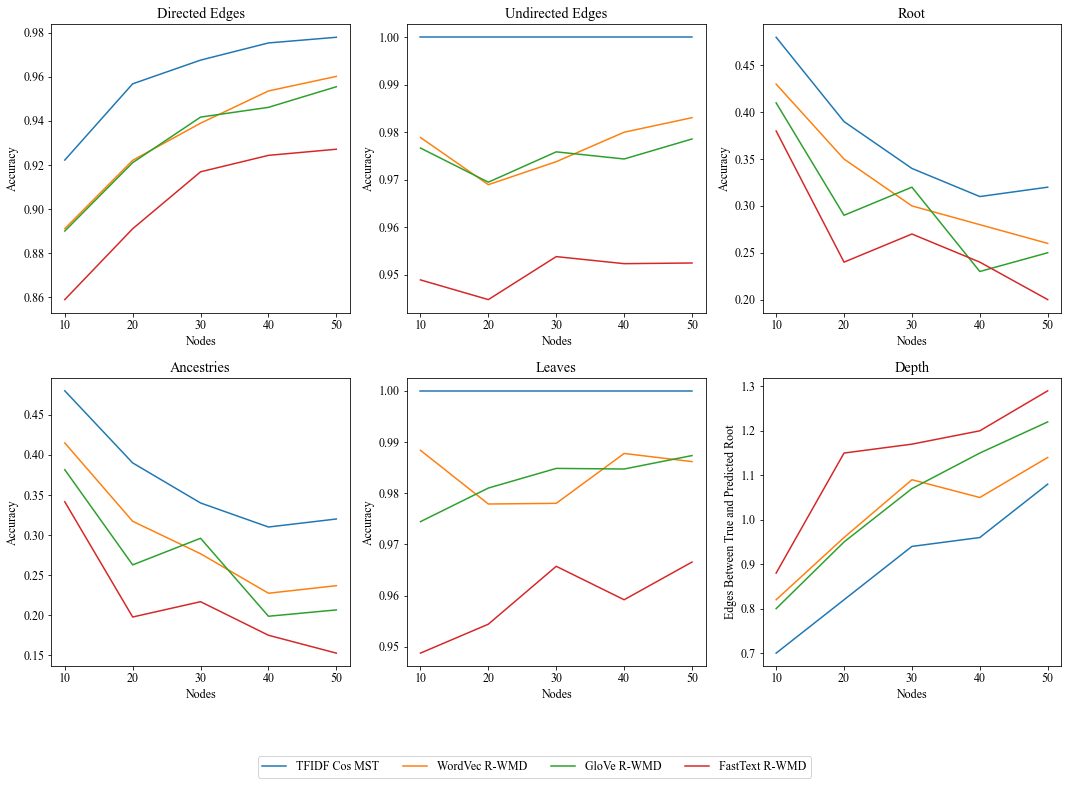

In [54]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([10, 20, 30, 40, 50])
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
})

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
labels = ['TFIDF Cos MST', 'WordVec R-WMD', 'GloVe R-WMD', 'FastText R-WMD']

axs[0, 0].plot(x, tfidfcosmst_accuracy[0][0])
axs[0, 0].plot(x, wordvecrwmd_accuracy[0][0])
axs[0, 0].plot(x, gloverwmd_accuracy[0][0])
axs[0, 0].plot(x, fasttextrwmd_accuracy[0][0])
axs[0, 0].set_title('Directed Edges')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xlabel('Nodes')

axs[0, 1].plot(x, tfidfcosmst_accuracy[0][1])
axs[0, 1].plot(x, wordvecrwmd_accuracy[0][1])
axs[0, 1].plot(x, gloverwmd_accuracy[0][1])
axs[0, 1].plot(x, fasttextrwmd_accuracy[0][1])
axs[0, 1].set_title('Undirected Edges')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('Nodes')

axs[0, 2].plot(x, tfidfcosmst_accuracy[0][2])
axs[0, 2].plot(x, wordvecrwmd_accuracy[0][2])
axs[0, 2].plot(x, gloverwmd_accuracy[0][2])
axs[0, 2].plot(x, fasttextrwmd_accuracy[0][2])
axs[0, 2].set_title('Root')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].set_xlabel('Nodes')

axs[1, 0].plot(x, tfidfcosmst_accuracy[0][3])
axs[1, 0].plot(x, wordvecrwmd_accuracy[0][3])
axs[1, 0].plot(x, gloverwmd_accuracy[0][3])
axs[1, 0].plot(x, fasttextrwmd_accuracy[0][3])
axs[1, 0].set_title('Ancestries')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_xlabel('Nodes')

axs[1, 1].plot(x, tfidfcosmst_accuracy[0][4])
axs[1, 1].plot(x, wordvecrwmd_accuracy[0][4])
axs[1, 1].plot(x, gloverwmd_accuracy[0][4])
axs[1, 1].plot(x, fasttextrwmd_accuracy[0][4])
axs[1, 1].set_title('Leaves')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_xlabel('Nodes')

axs[1, 2].plot(x, tfidfcosmst_accuracy[0][5])
axs[1, 2].plot(x, wordvecrwmd_accuracy[0][5])
axs[1, 2].plot(x, gloverwmd_accuracy[0][5])
axs[1, 2].plot(x, fasttextrwmd_accuracy[0][5])
axs[1, 2].set_title('Depth')
axs[1, 2].set_ylabel('Edges Between True and Predicted Root')
axs[1, 2].set_xlabel('Nodes')

fig.legend( labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.tight_layout()

plt.show()


In [48]:
import os
#delete predicted stemma files if need be.I use htis to delete the predicted stemmata. 
def delete_files_with_string(root_dir, target_string):
    # Walk through all directories and files in root_dir
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            # Check if the target_string is in the current filename
            if target_string in filename:
                # Construct full file path
                file_path = os.path.join(dirpath, filename)
                # Delete the file
                os.remove(file_path)
                print(f"Deleted: {file_path}")


# Word Mover Distance (Only done for Parzival)

In [85]:
#same as for reduced word mover but with word mover distance.
def preprocess(text):
    text=text.replace('\n','')
    text=text.translate(str.maketrans('', '', string.punctuation))

    return [word.lower() for word in text.split()]

def get_vectors(doc,model):
    vectors = []
    doc=preprocess(doc)
    for word in doc:
        if word in model:
            vectors.append(model[word])
    return np.array(vectors)
    
    return rwmd(doc1_vectors, doc2_vectors)

def wmd_mst(documents,model,variant_names):
    dissimilarity_matrix=np.zeros((len(documents),len(documents)))
    for i in range(len(documents)):
        for j in range(i+1,len(documents)):
            dissimilarity_matrix[i][j]=model.wmdistance(preprocess(documents[i]),preprocess(documents[j]))
            dissimilarity_matrix[j][i]=dissimilarity_matrix[i][j]
            
    G = nx.Graph()

    for i in range(len(variant_names)):
        for j in range(i + 1, len(variant_names)):
            G.add_edge(variant_names[i], variant_names[j], weight=dissimilarity_matrix[i, j])

    # Compute the minimum spanning tree (Kruskal's algorithm is the default)
    mst = nx.minimum_spanning_tree(G)
    
    root=minimum_heuristic(mst)
    mst=direct_edges_away_from_root(mst,root)
            
    return mst, dissimilarity_matrix

# Parzival

In [40]:
#in this section we show how the trees and average signed distances were calculated for hte real world 
#datasets
def positioning(graph):
    pos_dict = {}
    for i, node_list in enumerate(nx.topological_generations(graph)):
        x_offset = 0.0#len(node_list) / 2
        y_offset = 0.1
        for j, name in enumerate(node_list):
            pos_dict[name] = (j - x_offset, -i + j * y_offset)

    return pos_dict
import matplotlib.pyplot as plt

#make parzival correct stemma for comparison
filenames,contents=read_text_files('C:/Users/Darren Zammit/Desktop/full')
parzival = nx.Graph()
parzival.add_edges_from([('p17','p9'),('p17','p18'),('p17','p19'),('p19','p20'),('p9','p21'),('p21','p4'),('p21','p1'),('p9','p7'),('p7','p3'),('p20','p10'),('p20','p5'),('p19','p11'),('p19','p8'),('p8','p6'),('p8','p14'),('p18','p2'),('p18','p13'),('p18','p15'),('p18','p16'),('p13','p12')])


#mst,cosine_dissimilarity_matrix_df = rwmd_mst(contents,word2vec_model,filenames)
#Signed_Distance(mst.to_undirected(),parzival,filenames)



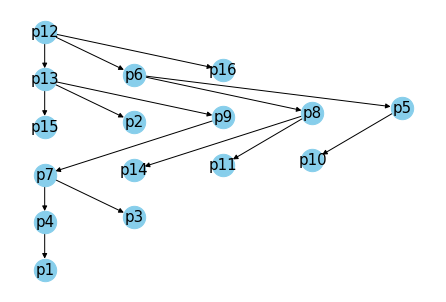

In [62]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()


In [64]:
mst,dissimilarity_matrix = rwmd_mst(contents,glove_model,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


77.85714285714286

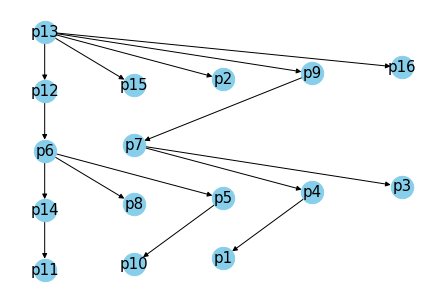

In [65]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()


In [68]:
mst,dissimilarity_matrix = rwmd_mst(contents,fasttext_model.wv,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


76.96428571428571

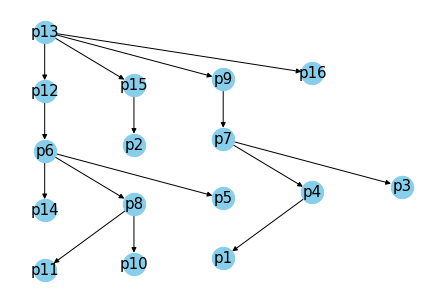

In [69]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()


In [72]:
mst,dissimilarity_matrix = tfidf_cos(contents,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


71.57738095238095

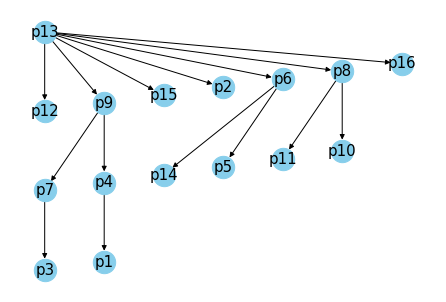

In [90]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()


In [95]:
mst,dissimilarity_matrix=wmd_mst(contents,word2vec_model,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


71.63690476190476

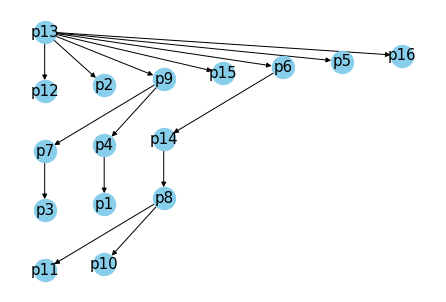

In [96]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()


In [93]:
mst,dissimilarity_matrix=wmd_mst(contents,glove_model,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


74.85119047619048

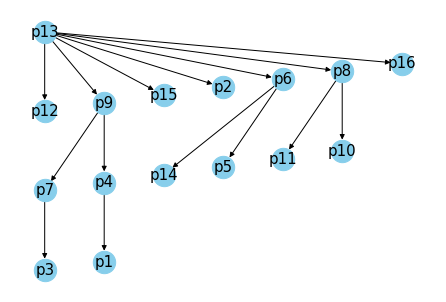

In [94]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

# Show the plot
plt.show()

In [97]:
mst,dissimilarity_matrix=wmd_mst(contents,fasttext_model.wv,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


74.43452380952381

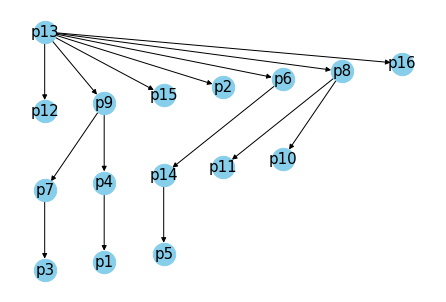

In [98]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

# Show the plot
plt.show()

In [105]:
mst,dissimilarity_matrix=wordembeddingsumcos(contents,fasttext_model.wv,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


75.80357142857143

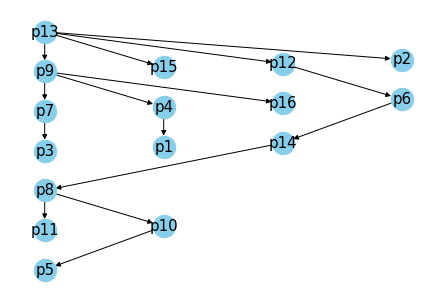

In [106]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()

In [107]:
mst,dissimilarity_matrix=wordembeddingsumcos(contents,glove_model,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


75.50595238095238

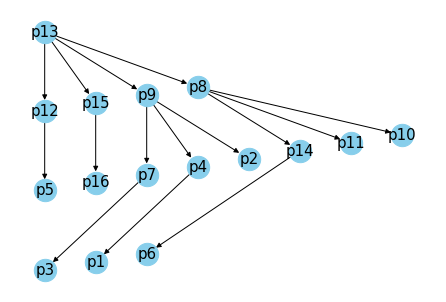

In [109]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()

In [110]:
mst,dissimilarity_matrix=wordembeddingsumcos(contents,word2vec_model,filenames)
Signed_Distance(mst.to_undirected(),parzival,filenames)


70.08928571428571

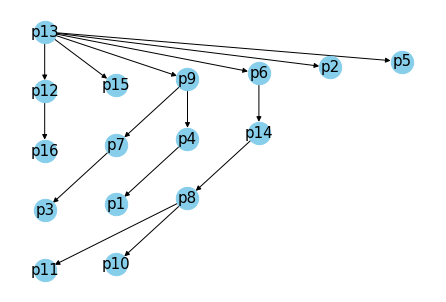

In [111]:
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)

plt.show()

# Phareta Fidei 10

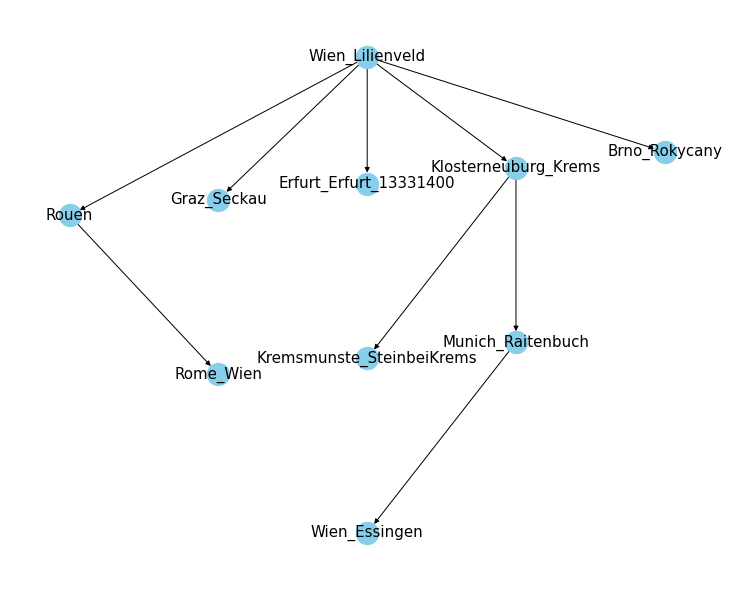

In [99]:
filenames,contents=read_text_files('C:/Users/Darren Zammit/Desktop/Thesis/datasets/phareta fidei 10')
mst,dissimilarity_matrix = tfidf_cos(contents,filenames)
plt.figure(figsize=(10, 8))

nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)
plt.show()

# Phareta Fidei 28


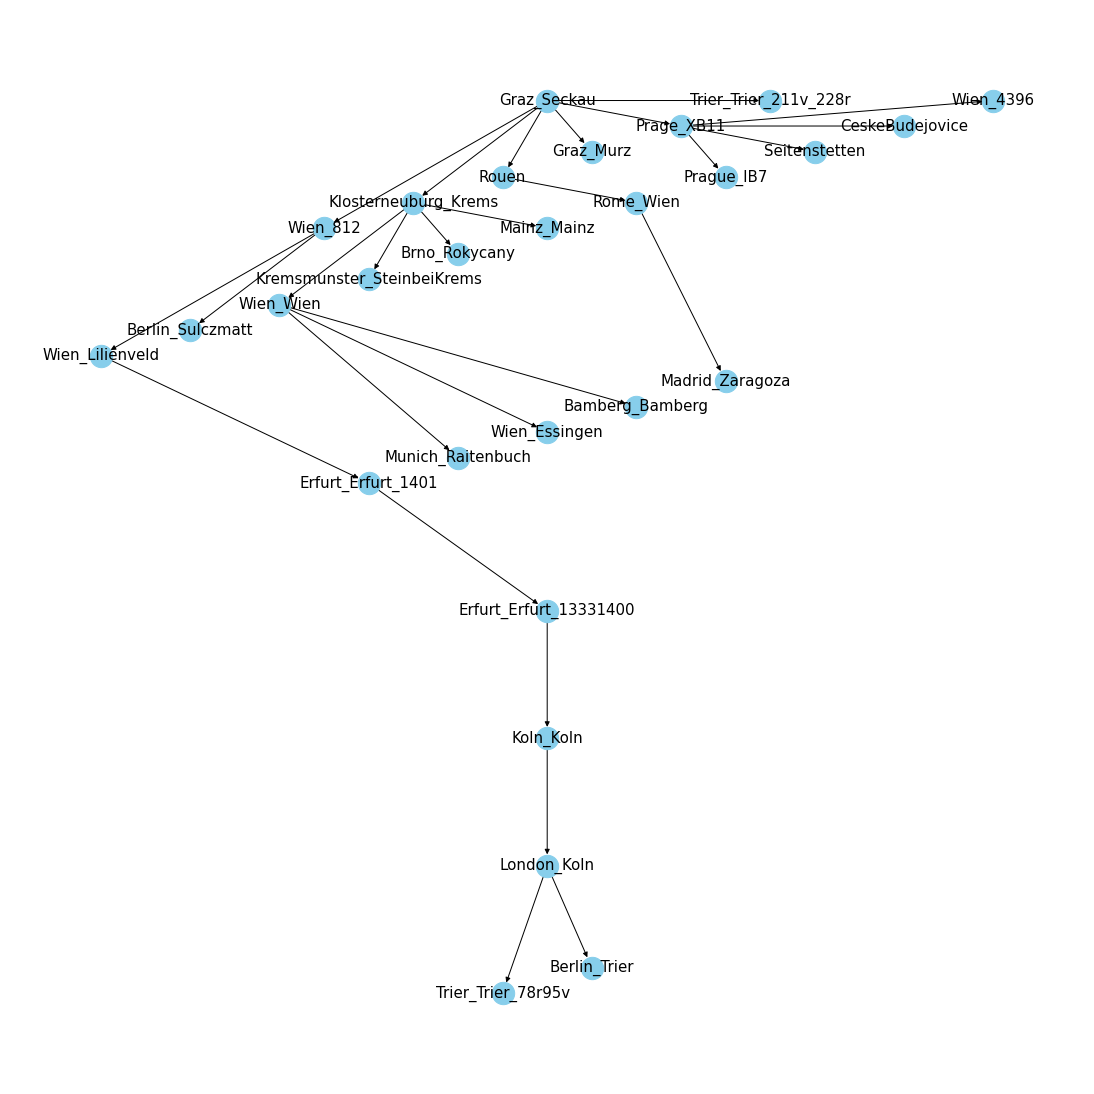

In [101]:
filenames,contents=read_text_files('C:/Users/Darren Zammit/Desktop/Thesis/datasets/phareta fidei 28')
mst,dissimilarity_matrix = tfidf_cos(contents,filenames)
plt.figure(figsize=(15, 15))
def positioning(graph):
    pos_dict = {}
    for i, node_list in enumerate(nx.topological_generations(graph)):
        x_offset = len(node_list) / 2
        y_offset = 0.2
        for j, name in enumerate(node_list):
            pos_dict[name] = (j - x_offset, -i + j * y_offset)

    return pos_dict
nx.draw(mst, positioning(mst), with_labels=True, node_color='skyblue', node_size=500, edge_color='k', linewidths=1, font_size=15)
plt.show()

# Heinrichi

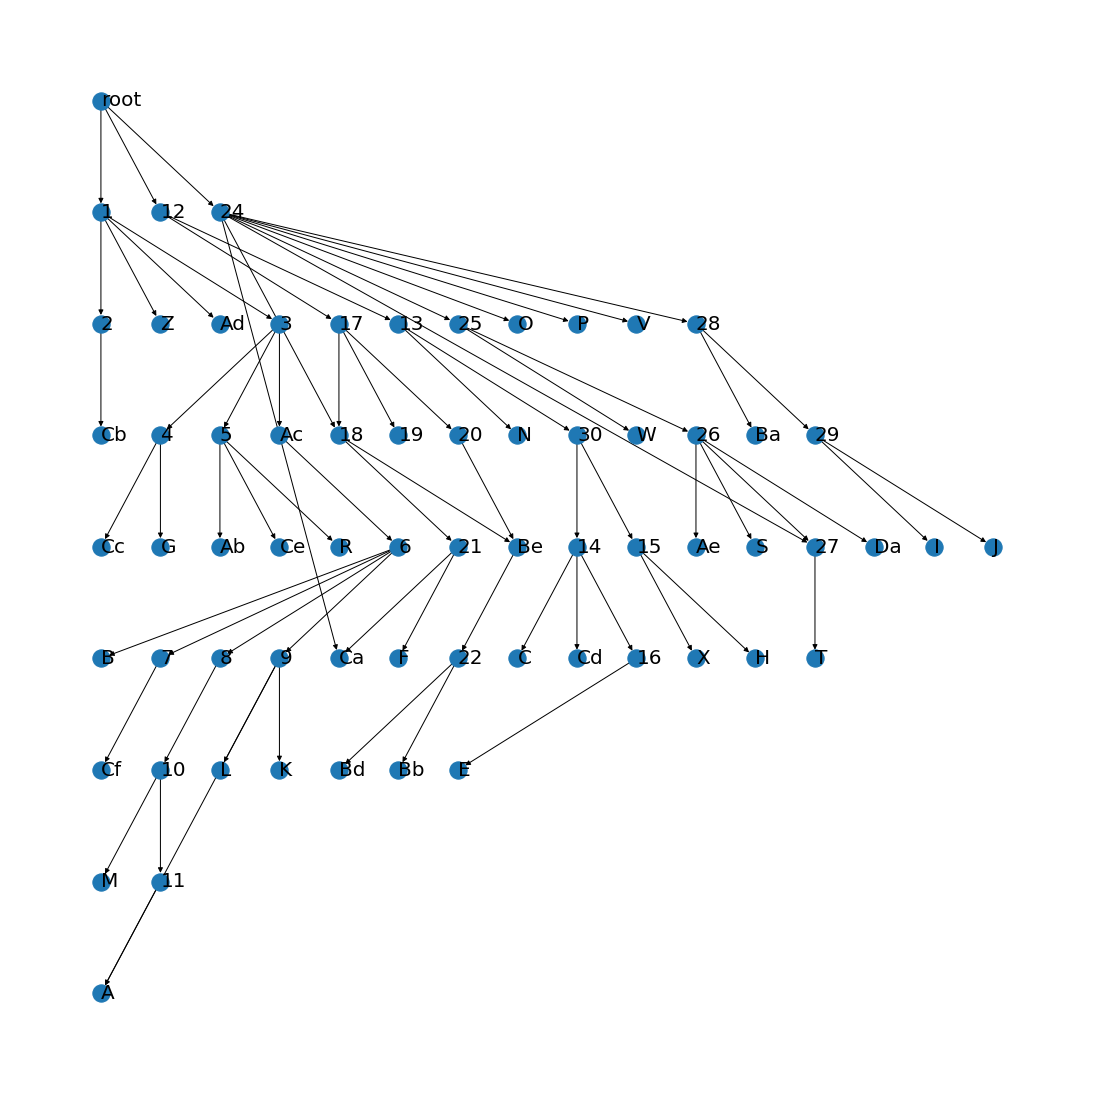

In [111]:
heinrichc = nx.DiGraph()

def positioning(graph):
    pos_dict = {}
    for i, node_list in enumerate(nx.topological_generations(graph)):
        x_offset = 0.0#len(node_list) / 2
        y_offset = 0.0
        for j, name in enumerate(node_list):
            pos_dict[name] = (j - x_offset, -i + j * y_offset)

    return pos_dict
heinrichc.add_edges_from([('root','1'),('1','2'),('2','Cb'),
                  ('1','Z'),('1','Ad'),('1','3'),('3','4'),
                  ('3','5'),('3','Ac'),('4','Cc'),
                  ('4','G'),('5','Ab'),('5','Ce'),
                  ('5','R'),('Ac','6'),('6','B'),('6','7'),
                 ('6','8'),('6','9'),('7','Cf'),('8','10'),
                 ('9','L'),('9','K'),('10','M'),('10','11'),('11','A')])

heinrichc.add_edges_from([('root','12'),('root','12'),('12','17'),('12','13'),('13','N')
                  ,('15','X'),('15','H'),('13','30'),('30','14'),('14','C'),('14','Cd'),('14','16'),('30','15')
                  ,('16','E'),('17','18'),('17','19'),('17','20'),('18','21'),('21','Ca'),('21','F'),('18','Be'),('20','Be'),('Be','22'),('22','Bd'),('22','Bb')])
                
                
heinrichc.add_edges_from([('root','24'),('24','25'),('25','W'),('25','26')
                  ,('26','Ae'),('26','S'),('26','27'),('27','T')
                  ,('24','O'),('24','P'),('24','V'),('24','28')
                  ,('28','Ba'),('28','29'),('29','I'),('29','J')
                  ,('26','Da'),('9','A'),('24','18'),('24','Ca'),('24','27')])

#contamination cases
#('9','A'),('24','18'),('24','Ca'),('24','27')

plt.figure(figsize=(15, 15))
pos=positioning(heinrichc)
nx.draw(heinrichc, pos)
nx.draw_networkx_labels(heinrichc, pos, horizontalalignment="left", font_size=20)
plt.show()
